In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"onssaadallah","key":"987ade7341423436ba3722a43856bcfc"}'}

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sayanf/flickr8k

mkdir: cannot create directory ‘/root/.kaggle’: File exists
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
!unzip flickr8k.zip
!mv Flickr8k_Dataset Flickr8k_images
!mv Flickr8k_text Flickr8k_annotations
!ls

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Flickr8k_Dataset/2847514745_9a35493023.jpg  
  inflating: Flickr8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: Flickr8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: Flickr8k_Dataset/2848266893_9693c66275.jpg  
  inflating: Flickr8k_Dataset/2848571082_26454cb981.jpg  
  inflating: Flickr8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: Flickr8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: Flickr8k_Dataset/2849194983_2968c72832.jpg  
  inflating: Flickr8k_Dataset/2850719435_221f15e951.jpg  
  inflating: Flickr8k_Dataset/2851198725_37b6027625.jpg  
  inflating: Flickr8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: Flickr8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: Flickr8k_Dataset/2852982055_8112d0964f.jpg  
  inflating: Flickr8k_Dataset/285306009_f6ddabe687.jpg  
  inflating: Flickr8k_Dataset/2853205396_4fbe8d7a73.jpg  
  inflating: Flickr8k_Dataset/2853407781_c9fea8eef4.j

In [31]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
from tqdm import tqdm
import torch.optim as optim
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter

import sys
import os
from torch.nn.utils.rnn import pad_sequence
from nltk.translate.bleu_score import sentence_bleu
import spacy
from torch.utils.data import Dataset
from PIL import Image
from collections import defaultdict
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
spacy_eng = spacy.load('en_core_web_sm')

In [32]:


class Vocabulary:
    def __init__(self):
        self.word2idx = {'<SOS>': 0, '<EOS>': 1, '<UNK>': 2, '<PAD>': 3}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.idx = 4

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions_list, min_word_freq=1):
        word_freq = defaultdict(int)
        spacy_eng = spacy.load('en_core_web_sm')

        for captions in captions_list:
            for caption in captions:
                words = [token.text for token in spacy_eng(caption.lower())]
                words = ['<SOS>'] + words + ['<EOS>']

                for word in words:
                    word_freq[word] += 1

        for word, freq in word_freq.items():
            if freq >= min_word_freq:
                self.add_word(word)
            else:
                self.word2idx[word] = self.word2idx['<UNK>']

    def index_to_word(self, index):
        return self.idx2word.get(index, '<UNK>')

class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, split='train', transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.split = split
        self.transform = transform
        self.image_paths = self.load_image_paths()
        self.annotations = self.load_annotations()
        self.vocab = self.build_vocab()

    def load_image_paths(self):
        image_paths = []
        with open(f'{self.annotation_folder}/Flickr_8k.{self.split}Images.txt', 'r') as f:
            lines = f.readlines()
            for l in lines:
              image_paths.append(l.strip())
        return image_paths

    def load_annotations(self):
        annotations = defaultdict(list)
        with open(f'{self.annotation_folder}/Flickr8k.token.txt', 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split('\t')
                image_name, caption = parts[0].split('#')[0], parts[1]
                annotations[image_name].append(caption)
        return annotations

    def build_vocab(self):
        vocab = Vocabulary()
        vocab.build_vocabulary(self.annotations.values())
        return vocab

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.image_paths[idx]
        image_path = f'{self.image_folder}/{image_name}'
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        captions = self.annotations[image_name]

        list_cap = []
        for caption in captions:
            words = ['<SOS>'] + nltk.word_tokenize(caption.lower()) + ['<EOS>']
            indices = [self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>']) for word in words]
            list_cap.append(indices)

        return {'image': image, 'captions': list_cap}


In [33]:
image_folder = '/content/Flickr8k_images'
annotation_folder = '/content/Flickr8k_annotations'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = Flickr8kDataset(image_folder, annotation_folder, split='train', transform=transform)
validation_dataset = Flickr8kDataset(image_folder, annotation_folder, split='dev', transform=transform)
test_dataset = Flickr8kDataset(image_folder, annotation_folder, split='test', transform=transform)

# YOU CAN ADD THE TEST TO THE VALIDATION OR TRAINIING IN ORDER TO HAVE MORE DATA

print(f"Train: {len(train_dataset)} imgs; Val: {len(validation_dataset)} imgs; Test: {len(test_dataset)} imgs")

Train: 6000 imgs; Val: 1000 imgs; Test: 1000 imgs


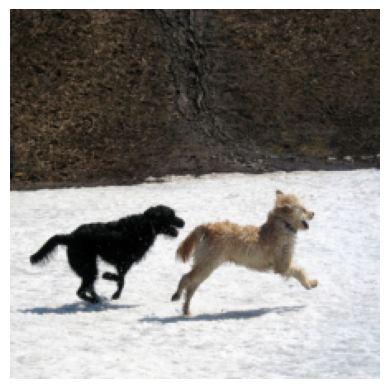

Captions:
<SOS> a black dog is running after a white dog in the snow . <EOS>
- [0, 4, 30, 31, 9, 119, 227, 4, 43, 31, 6, 26, 178, 18, 1]

<SOS> black dog chasing brown dog through snow <EOS>
- [0, 30, 31, 510, 44, 31, 124, 178, 1]

<SOS> two <UNK> chase each other across the snowy ground . <EOS>
- [0, 49, 2, 208, 39, 40, 460, 26, 336, 95, 18, 1]

<SOS> two <UNK> play together in the snow . <EOS>
- [0, 49, 2, 68, 277, 6, 26, 178, 18, 1]

<SOS> two <UNK> running through a low lying body of water . <EOS>
- [0, 49, 2, 119, 124, 4, 492, 586, 258, 13, 142, 18, 1]



In [34]:
def visualize_sample(split, i=0):
  sample = split[i]
  image, captions = sample['image'], sample['captions']

  # Convert PyTorch tensor to NumPy array and transpose the dimensions
  image_np = np.transpose(image.numpy(), (1, 2, 0))

  plt.imshow(image_np)
  plt.axis('off')
  plt.show()

  print("Captions:")
  for caption in captions:
    words = [split.vocab.idx2word[idx] for idx in caption]
    print(" ".join(word for word in words))
    print(f"- {caption}\n")

visualize_sample(train_dataset, 0)

In [35]:
vocab = train_dataset.vocab

VOCAB_SIZE = len(vocab.word2idx)

# Print the size of the vocabulary
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 7705


In [36]:
def collate_fn(batch):
  images = [item['image'] for item in batch]
  all_captions = [item['captions'] for item in batch]
  captions = [caption for captions in all_captions for caption in captions]
  max_len = max(len(caption) for caption in captions)
  padded_captions = nn.utils.rnn.pad_sequence(
      [torch.LongTensor(caption + [item.get('vocabulary', {}).get('word2idx', {}).get('<PAD>', 3)] * (max_len - len(caption))) for caption, item in zip(captions, batch)],
        batch_first=True,
        padding_value=batch[0].get('vocabulary', {}).get('word2idx', {}).get('<PAD>', 3)
    )

   return {'images': torch.stack(images), 'captions': padded_captions}


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [45]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size=1024):
        super(EncoderCNN, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(in_features=512, out_features=1024)
        self.embed = nn.Linear(in_features=1024, out_features=embed_size)
        self.dropout = nn.Dropout(p=0.5)
        self.prelu = nn.PReLU()

    def forward(self, images):
        batch_size, _, _, _ = images.size()
        images = images.view(batch_size, -1, 224, 224)  # Reshape images to (batch_size, channels * height, width)
        resnet_outputs = self.dropout(self.prelu(self.resnet(images)))
        embeddings = self.embed(resnet_outputs)
        return embeddings

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.lstm_cell = nn.LSTMCell(input_size=embed_size, hidden_size=hidden_size)
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions):
        batch_size, _ = features.size()

        # Initialize hidden and cell states
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(features.device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(features.device)

        # Reshape features to (batch_size, embed_size)
        features = features.view(batch_size, -1)

        # Initialize outputs tensor
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(features.device)
        captions_embed = self.embed(captions)

        for t in range(captions.size(1)):
            if t == 0:
                hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
            else:
                hidden_state, cell_state = self.lstm_cell(captions_embed[:, t - 1, :], (hidden_state, cell_state))

            out = self.fc_out(hidden_state)
            outputs[:, t, :] = out

        return outputs



In [77]:
learning_rate = 0.001
num_epochs = 150
patience = 30


early_stopping_counter = 0
best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
encoder = EncoderCNN(embed_size=1024).to(device)
decoder = DecoderRNN(embed_size=1024, hidden_size=512, vocab_size=VOCAB_SIZE).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
train_loss = list()
val_losses = list()
for epoch in range(1, num_epochs + 1):
    for i_step, batch_data in enumerate(train_dataloader, 1):
        images = batch_data['images'].to(device)
        captions = batch_data['captions'].to(device)

        # Pass the inputs through the CNN-RNN model
        features = encoder(images)
        captions_target = captions[:, 1:]
        captions_train = captions[:, :captions.shape[1] - 1]
        outputs = decoder(features, captions_train)

        # Calculate the batch loss
        loss = criterion(outputs.view(-1, VOCAB_SIZE), captions_target.contiguous().view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters in the optimizer
        optimizer.step()

        # Append the training loss
        train_loss.append(loss.item())

    # Validation loop
    with torch.no_grad():
        for batch_val_data in validation_dataloader:
            val_images = batch_val_data['images'].to(device)
            val_captions = batch_val_data['captions'].to(device)

            # Pass the inputs through the CNN-RNN model
            val_features = encoder(val_images)
            val_captions_target = val_captions[:, 1:]
            val_captions_train = val_captions[:, :val_captions.shape[1] - 1]
            val_outputs = decoder(val_features, val_captions_train)

            # Calculate the batch loss
            val_loss = criterion(val_outputs.view(-1, VOCAB_SIZE), val_captions_target.contiguous().view(-1))
            val_losses.append(val_loss.item())



    # Print training statistics
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.4f}, Val Loss: {np.mean(val_losses):.4f}')

    # Save the model if it has the best validation loss
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(decoder.state_dict(), 'decoder.pth')
        torch.save(encoder.state_dict(), 'encoder.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Check for early stopping
    if early_stopping_counter >= patience:
        print("Early stopping. Training finished.")
        break

Epoch [1/150], Loss: 2.4916, Val Loss: 2.0552
Epoch [2/150], Loss: 2.0524, Val Loss: 2.0207
Epoch [3/150], Loss: 1.8005, Val Loss: 1.9966
Epoch [4/150], Loss: 2.0647, Val Loss: 1.9809
Epoch [5/150], Loss: 2.2403, Val Loss: 1.9682
Epoch [6/150], Loss: 2.3040, Val Loss: 1.9579
Epoch [7/150], Loss: 1.2721, Val Loss: 1.9509
Epoch [8/150], Loss: 1.8091, Val Loss: 1.9449
Epoch [9/150], Loss: 2.0742, Val Loss: 1.9399
Epoch [10/150], Loss: 1.8300, Val Loss: 1.9354
Epoch [11/150], Loss: 1.5688, Val Loss: 1.9325
Epoch [12/150], Loss: 1.5418, Val Loss: 1.9298
Epoch [13/150], Loss: 2.0177, Val Loss: 1.9278
Epoch [14/150], Loss: 1.6002, Val Loss: 1.9260
Epoch [15/150], Loss: 1.1602, Val Loss: 1.9248
Epoch [16/150], Loss: 1.3649, Val Loss: 1.9237
Epoch [17/150], Loss: 1.8237, Val Loss: 1.9227
Epoch [18/150], Loss: 1.0495, Val Loss: 1.9224
Epoch [19/150], Loss: 1.6838, Val Loss: 1.9224
Epoch [20/150], Loss: 1.5666, Val Loss: 1.9224
Epoch [21/150], Loss: 1.3362, Val Loss: 1.9226
Epoch [22/150], Loss: 

In [80]:
import torch
from nltk.translate.bleu_score import sentence_bleu

def test(encoder, decoder, test_dataloader, max_caption_length, vocab, device):
    encoder.eval()
    decoder.eval()

    all_references = []
    all_hypotheses = []

    for batch_test_data in test_dataloader:
        test_images = batch_test_data['images'].to(device)

        # Pass the inputs through the CNN-RNN model
        test_features = encoder(test_images)

        # Initialize the input for the decoder with <SOS> token
        input_captions = torch.ones((test_images.size(0), 1)).long().to(device) * 0

        references_batch = []
        hypotheses_batch = []

        # Initialize the hidden and cell states
        batch_size = test_images.size(0)
        hidden_state = torch.zeros((batch_size, decoder.hidden_size)).to(device)
        cell_state = torch.zeros((batch_size, decoder.hidden_size)).to(device)

        captions = []

        # Generate captions word by word
        for _ in range(max_caption_length):  # You need to define max_caption_length
            # Embed the input captions
            captions_embed = decoder.embed(input_captions)

            # LSTM cell
            hidden_state, cell_state = decoder.lstm_cell(captions_embed[:, 0, :], (hidden_state, cell_state))

            # Output from the attention mechanism
            out = decoder.fc_out(hidden_state)

            # Predict the next word
            _, predicted_word = out.max(1)

            # Append the predicted word to the captions
            captions.append(predicted_word.unsqueeze(1))

            # Prepare the input for the next time step
            input_captions = predicted_word.unsqueeze(1)

            # Collect generated words for the BLEU score calculation
            hypotheses_batch.append(vocab.idx2word[predicted_word[0].item()])

        # Collect ground truth captions for the BLEU score calculation
        references_batch.append([vocab.idx2word[idx.item()] for idx in batch_test_data['captions'][:, 1:].reshape(-1)])

        # Calculate BLEU score for this batch
        bleu_score = sentence_bleu(references_batch, hypotheses_batch)

        # Collect references and hypotheses for all test images
        all_references.extend(references_batch)
        all_hypotheses.extend(hypotheses_batch)

    # Calculate the average BLEU score over all test images
    average_bleu_score = sentence_bleu(all_references, all_hypotheses)
    print(f"Average BLEU Score over all test images: {average_bleu_score:.4f}")


# Load  models
encoder = EncoderCNN(embed_size=1024).to(device)
encoder.load_state_dict(torch.load('encoder.pth'))
encoder.eval()

decoder = DecoderRNN(embed_size=1024, hidden_size=512, vocab_size=VOCAB_SIZE).to(device)
decoder.load_state_dict(torch.load('decoder.pth'))
decoder.eval()
test(encoder, decoder, test_dataloader,10, vocab, device)


Average BLEU Score over all test images: 0.2902


In [75]:
# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/Assignment_3_test_set.zip'



# Unzip the file
!unzip $zip_file_path

Archive:  /content/drive/MyDrive/Assignment_3_test_set.zip
replace Assignment 3 Test set/045759d0c8aa5aa26b9492da524146fb.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_caption_length=25
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_names = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_names[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {"image": image, "image_name": self.image_names[idx]}

submission_test_dataset_path = "/content/Assignment 3 Test set"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

submission_test_dataset = CustomDataset(
    folder_path=submission_test_dataset_path,
    transform=transform
)

test_dataloader_submission = DataLoader(submission_test_dataset, batch_size=32, shuffle=False, num_workers=2)

predictions = []

for batch_test_data in test_dataloader_submission:
    test_images = batch_test_data['image'].to(device)

    # Pass the inputs through the CNN-RNN model
    test_features = encoder(test_images)

    # Initialize the input for the decoder with <SOS> token
    input_captions = torch.ones((test_images.size(0), 1)).long().to(device) * 0

    batch_size = test_images.size(0)
    hidden_state = torch.zeros((batch_size, decoder.hidden_size)).to(device)
    cell_state = torch.zeros((batch_size, decoder.hidden_size)).to(device)

    batch_predictions = []

    for _ in range(max_caption_length):
        # Embed the input captions
        captions_embed = decoder.embed(input_captions)

        # LSTM cell
        hidden_state, cell_state = decoder.lstm_cell(captions_embed[:, 0, :], (hidden_state, cell_state))

        # Output from the attention mechanism
        out = decoder.fc_out(hidden_state)

        # Predict the next word
        _, predicted_word = out.max(1)

        batch_predictions.append([
            vocab.idx2word[predicted_word[i].item()]
            for i in range(batch_size)
            ])


        # Prepare the input for the next time step
        input_captions = predicted_word.unsqueeze(1)

    # Join the words to form the predicted caption sentence for each image in the batch
    for i in range(batch_size):
        # Exclude specific tokens while joining
        predicted_caption = " ".join(
            batch_predictions[j][i]
            for j in range(min(max_caption_length, len(batch_predictions)))
            if batch_predictions[j][i] not in ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
        )
        image_name = batch_test_data['image_name'][i]
        predictions.append((image_name, predicted_caption))


# Create a DataFrame from the predictions list
submission_df = pd.DataFrame(predictions, columns=["image_name", "predicted_caption"])

# Save the DataFrame to a CSV file
submission_path = "/content/drive/MyDrive/submission23.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved at {submission_path}")


Submission file saved at /content/drive/MyDrive/submission23.csv
